In [49]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [50]:
# Define the base directory
base_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [51]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
COVID.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [52]:
# Define paths
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load metadata
metadata = {}
for cls in classes:
    metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx' if cls != 'Viral Pneumonia' else 'Viral Pneumonia.metadata.xlsx')
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")

Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [53]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [54]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [55]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [56]:
# Define the root directory of the dataset
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Map images to labels
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
print(f"Total Mapped Data: {len(all_mapped_data)}")
for img_path, label in all_mapped_data[:10]:  # Only print the first 10 items to avoid large output
    print(f"Image Path: {img_path}, Label: {label}")


# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Total Mapped Data: 21165
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-10.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-100.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1000.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1001.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1002.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID

,image_path,label
0,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
1,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
2,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
3,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
4,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0


Total images mapped: 21165


In [57]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")

Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [58]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [59]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
# Compute class weights
train_labels = [sample[1] for sample in train_data]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [60]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 16
num_workers = 0 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


In [61]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")


Train data size: 14815
Validation data size: 2116
Test data size: 4234


In [62]:
print(train_data[0])  # Should print something like: (image_path, label)
print(val_data[0])
print(test_data[0])


('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-278.png', 0)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\Normal\\images\\Normal-4150.png', 2)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-868.png', 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.7511113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


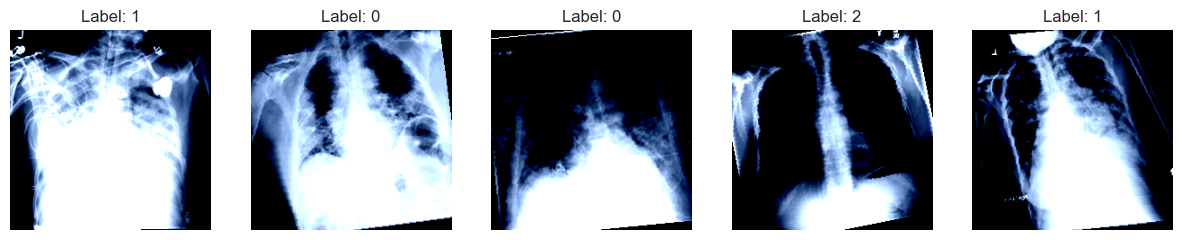

In [63]:
import matplotlib.pyplot as plt

# Check first batch
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx == 0:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            ax = axes[i]
            ax.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
            ax.set_title(f"Label: {labels[i].item()}")
            ax.axis('off')
        plt.show()
        break  # Exit after the first batch


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11536\514221396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')


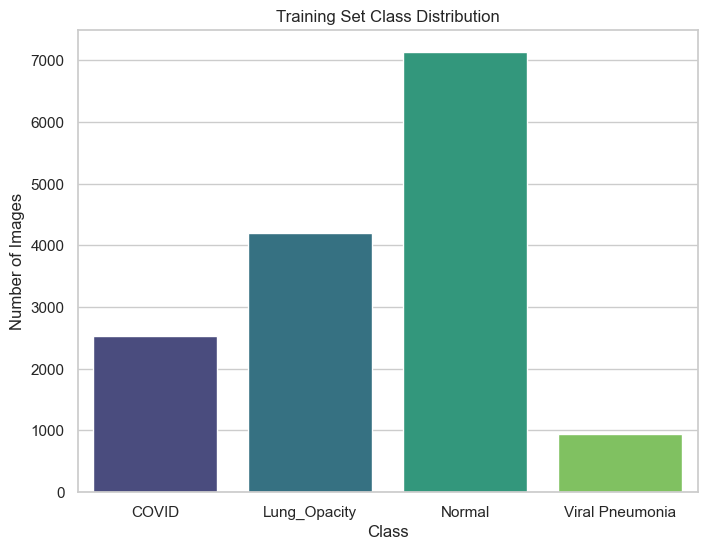

In [64]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [65]:
# import matplotlib.pyplot as plt

# def display_images_from_loader(loader, num_images=5):
#     data_iter = iter(loader)
#     images, labels = next(data_iter)

#     # Ensure num_images does not exceed batch size
#     num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

#     # Create a figure with subplots
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

#     for i in range(num_images):
#         ax = axes[i]
#         image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
#         ax.imshow(image)
#         ax.set_title(f"Label: {labels[i].item()}")
#         ax.axis('off')
#         print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

#     plt.show()

# # Check train_loader
# print("Training images:")
# display_images_from_loader(train_loader)

# # Check val_loader
# print("Validation images:")
# display_images_from_loader(val_loader)

# # Check test_loader
# print("Testing images:")
# display_images_from_loader(test_loader)


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [67]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        
        # Load MobileNetV2 without ImageNet weights (pretrained=False)
        self.model = models.mobilenet_v2(pretrained=False)
        
        # Replace the classifier with the number of classes you need
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, x):
        return self.model(x)

## GCT block

In [69]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# # Define the GCT Attention Mechanism
# class GCTAttention(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3):
#         super(GCTAttention, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
        
#         # Convolution layer to generate query, key, and value
#         self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
#         # Output convolution to project the attention result
#         self.output_conv = nn.Conv2d(out_channels, in_channels, kernel_size=1)

#     def forward(self, x):
#         batch_size, _, height, width = x.size()
        
#         # Generate queries, keys, and values
#         query = self.query_conv(x).view(batch_size, self.out_channels, -1)
#         key = self.key_conv(x).view(batch_size, self.out_channels, -1)
#         value = self.value_conv(x).view(batch_size, self.out_channels, -1)
        
#         # Compute attention scores (dot product of query and key)
#         attention = torch.bmm(query.permute(0, 2, 1), key)
#         attention = F.softmax(attention, dim=-1)
        
#         # Apply attention to values
#         attended_values = torch.bmm(value, attention)
        
#         # Reshape back to the image shape
#         attended_values = attended_values.view(batch_size, self.out_channels, height, width)
        
#         # Apply the output convolution to map the result back to the input space
#         output = self.output_conv(attended_values)
        
#         return output

In [70]:
import torch.nn as nn
import torchvision.models as models

class GCTAttention(nn.Module):
    def __init__(self, in_channels):
        super(GCTAttention, self).__init__()
        self.in_channels = in_channels
        
        # Global Context Attention
        self.gamma = nn.Parameter(torch.zeros(1))  # Scaling parameter
        
        # Convolution layer to aggregate global information
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        # Compute channel-wise global context
        context = x.mean(dim=(2, 3), keepdim=True)  # Global average pooling
        
        # Transform the context
        transformed = self.conv(context)
        
        # Apply channel-wise attention
        out = self.gamma * transformed + x
        
        return out


class MobileNetV2WithGCT(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithGCT, self).__init__()
        
        # Load MobileNetV2 without pre-trained weights
        self.mobilenet = models.mobilenet_v2(weights=None)
        
        # Get the number of output channels from the last convolutional layer
        bottleneck_channels = self.mobilenet.last_channel
        
        # Define GCT block for the last feature map output
        self.gct = GCTAttention(in_channels=bottleneck_channels)
        
        # Replace the classifier with a new one for the specified number of classes
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(bottleneck_channels, num_classes)
        )
    
    def forward(self, x):
        # Forward pass through MobileNetV2 feature extractor
        x = self.mobilenet.features(x)
        
        # Apply GCT block after the last feature extractor
        x = self.gct(x)
        
        # Global average pooling
        x = x.mean([2, 3])  # Equivalent to nn.AdaptiveAvgPool2d((1, 1)) and flatten
        
        # Forward pass through the classifier
        x = self.mobilenet.classifier(x)
        
        return x


## model with attention block 

In [72]:
# import torch.nn as nn
# import torchvision.models as models

# class MobileNetV2WithGCT(nn.Module):
#     def __init__(self, num_classes):
#         super(MobileNetV2WithGCT, self).__init__()
        
#         # Load MobileNetV2 without pre-trained weights
#         self.mobilenet = models.mobilenet_v2(weights=None)
        
#         # Get the number of output channels from the last convolutional layer
#         bottleneck_channels = self.mobilenet.last_channel
        
#         # Define an FCA block to match the bottleneck output channels
#         self.gct = GCTAttention(channels=bottleneck_channels)
        
#         # Replace the classifier with a new one for the specified number of classes
#         self.mobilenet.classifier = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(bottleneck_channels, num_classes)
#         )
    
#     def forward(self, x):
#         # Forward pass through MobileNetV2 feature extractor
#         x = self.mobilenet.features(x)
        
#         # Apply gct block after bottleneck
#         x = self.gct(x)
        
#         # Global average pooling
#         x = x.mean([2, 3])  # Equivalent to nn.AdaptiveAvgPool2d((1, 1)) and flatten
        
#         # Forward pass through the classifier
#         x = self.mobilenet.classifier(x)
        
#         return x


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 4  # Modify based on your dataset (e.g., 2 for binary classification, 4 for multi-class)
model = MobileNetV2WithGCT(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

MobileNetV2WithGCT(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [74]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:21<00:00,  6.54it/s]


Train Loss: 1.0580, Accuracy: 0.5006


Val Phase: 100%|██████████| 133/133 [00:10<00:00, 12.48it/s]


Val Loss: 0.8290, Accuracy: 0.5525
End of Epoch 1: Train Loss - 1.0580, Val Loss - 0.8290

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.37it/s]


Train Loss: 0.8169, Accuracy: 0.6174


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.50it/s]


Val Loss: 0.6319, Accuracy: 0.7150
End of Epoch 2: Train Loss - 0.8169, Val Loss - 0.6319

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:09<00:00,  7.15it/s]


Train Loss: 0.7438, Accuracy: 0.6534


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.66it/s]


Val Loss: 0.5649, Accuracy: 0.7344
End of Epoch 3: Train Loss - 0.7438, Val Loss - 0.5649

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:54<00:00,  8.08it/s]


Train Loss: 0.6815, Accuracy: 0.6854


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.20it/s]


Val Loss: 0.5055, Accuracy: 0.7784
End of Epoch 4: Train Loss - 0.6815, Val Loss - 0.5055

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:54<00:00,  8.08it/s]


Train Loss: 0.6150, Accuracy: 0.7149


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.17it/s]


Val Loss: 0.5577, Accuracy: 0.7060
End of Epoch 5: Train Loss - 0.6150, Val Loss - 0.5577

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:54<00:00,  8.09it/s]


Train Loss: 0.5836, Accuracy: 0.7308


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.08it/s]


Val Loss: 0.4751, Accuracy: 0.7448
End of Epoch 6: Train Loss - 0.5836, Val Loss - 0.4751

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:54<00:00,  8.08it/s]


Train Loss: 0.5321, Accuracy: 0.7551


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.16it/s]


Val Loss: 0.4251, Accuracy: 0.7817
End of Epoch 7: Train Loss - 0.5321, Val Loss - 0.4251

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:53<00:00,  8.16it/s]


Train Loss: 0.5076, Accuracy: 0.7695


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.00it/s]


Val Loss: 0.3980, Accuracy: 0.7987
End of Epoch 8: Train Loss - 0.5076, Val Loss - 0.3980

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.43it/s]


Train Loss: 0.4711, Accuracy: 0.7872


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.67it/s]


Val Loss: 0.3685, Accuracy: 0.8341
End of Epoch 9: Train Loss - 0.4711, Val Loss - 0.3685

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.42it/s]


Train Loss: 0.4468, Accuracy: 0.7926


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.60it/s]


Val Loss: 0.3804, Accuracy: 0.8374
End of Epoch 10: Train Loss - 0.4468, Val Loss - 0.3804

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:50<00:00,  8.41it/s]


Train Loss: 0.4036, Accuracy: 0.8126


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.95it/s]


Val Loss: 0.3262, Accuracy: 0.8625
End of Epoch 11: Train Loss - 0.4036, Val Loss - 0.3262

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:50<00:00,  8.40it/s]


Train Loss: 0.3884, Accuracy: 0.8224


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.74it/s]


Val Loss: 0.3226, Accuracy: 0.8544
End of Epoch 12: Train Loss - 0.3884, Val Loss - 0.3226

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.43it/s]


Train Loss: 0.3811, Accuracy: 0.8263


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.90it/s]


Val Loss: 0.3091, Accuracy: 0.8663
End of Epoch 13: Train Loss - 0.3811, Val Loss - 0.3091

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.51it/s]


Train Loss: 0.3725, Accuracy: 0.8293


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.09it/s]


Val Loss: 0.3059, Accuracy: 0.8644
End of Epoch 14: Train Loss - 0.3725, Val Loss - 0.3059

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.51it/s]


Train Loss: 0.3651, Accuracy: 0.8329


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.77it/s]


Val Loss: 0.3041, Accuracy: 0.8667
End of Epoch 15: Train Loss - 0.3651, Val Loss - 0.3041

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.54it/s]


Train Loss: 0.3658, Accuracy: 0.8333


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.05it/s]


Val Loss: 0.3030, Accuracy: 0.8696
End of Epoch 16: Train Loss - 0.3658, Val Loss - 0.3030

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.53it/s]


Train Loss: 0.3572, Accuracy: 0.8407


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.13it/s]


Val Loss: 0.3017, Accuracy: 0.8606
End of Epoch 17: Train Loss - 0.3572, Val Loss - 0.3017

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.49it/s]


Train Loss: 0.3603, Accuracy: 0.8373


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.79it/s]


Val Loss: 0.3003, Accuracy: 0.8776
End of Epoch 18: Train Loss - 0.3603, Val Loss - 0.3003

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.48it/s]


Train Loss: 0.3496, Accuracy: 0.8391


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.86it/s]


Val Loss: 0.2904, Accuracy: 0.8715
End of Epoch 19: Train Loss - 0.3496, Val Loss - 0.2904

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.49it/s]


Train Loss: 0.3491, Accuracy: 0.8420


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.88it/s]


Val Loss: 0.2956, Accuracy: 0.8785
End of Epoch 20: Train Loss - 0.3491, Val Loss - 0.2956

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.50it/s]


Train Loss: 0.3374, Accuracy: 0.8457


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.90it/s]


Val Loss: 0.2973, Accuracy: 0.8648
End of Epoch 21: Train Loss - 0.3374, Val Loss - 0.2973

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.50it/s]


Train Loss: 0.3325, Accuracy: 0.8493


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.94it/s]


Val Loss: 0.2963, Accuracy: 0.8733
End of Epoch 22: Train Loss - 0.3325, Val Loss - 0.2963

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:49<00:00,  8.49it/s]


Train Loss: 0.3385, Accuracy: 0.8437


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.19it/s]


Val Loss: 0.2856, Accuracy: 0.8757
End of Epoch 23: Train Loss - 0.3385, Val Loss - 0.2856

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.50it/s]


Train Loss: 0.3382, Accuracy: 0.8485


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.97it/s]


Val Loss: 0.2924, Accuracy: 0.8823
End of Epoch 24: Train Loss - 0.3382, Val Loss - 0.2924

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:48<00:00,  8.50it/s]


Train Loss: 0.3430, Accuracy: 0.8410


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 16.09it/s]

Val Loss: 0.2907, Accuracy: 0.8828
End of Epoch 25: Train Loss - 0.3430, Val Loss - 0.2907

Training complete. Best Validation Accuracy: 0.8828


In [76]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 265/265 [00:19<00:00, 13.43it/s]


Classification Report:
                 precision    recall  f1-score   support

          COVID       0.85      0.91      0.88       723
   Lung_Opacity       0.87      0.82      0.84      1203
         Normal       0.89      0.89      0.89      2039
Viral Pneumonia       0.90      0.95      0.92       269

       accuracy                           0.88      4234
      macro avg       0.88      0.89      0.88      4234
   weighted avg       0.88      0.88      0.88      4234



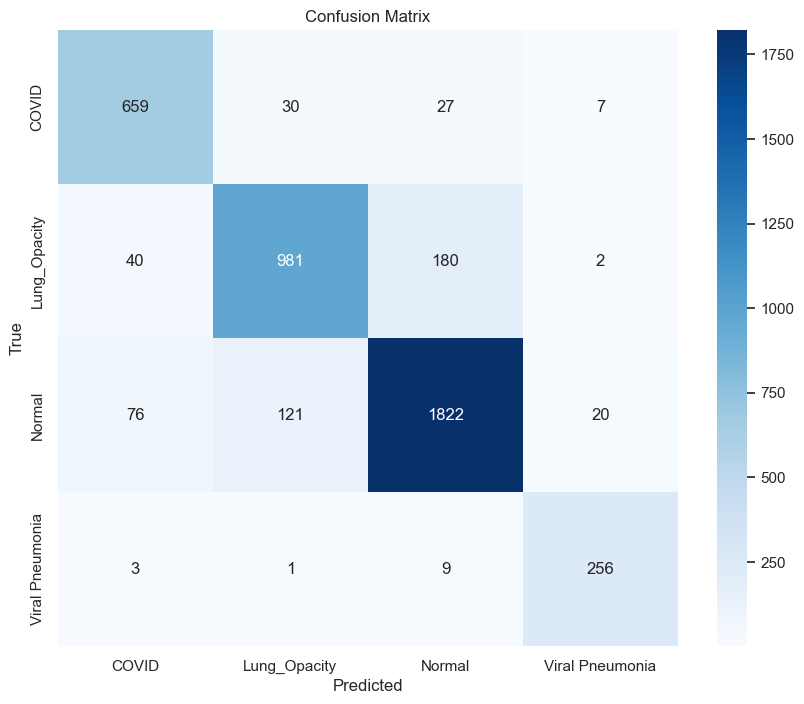

In [77]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

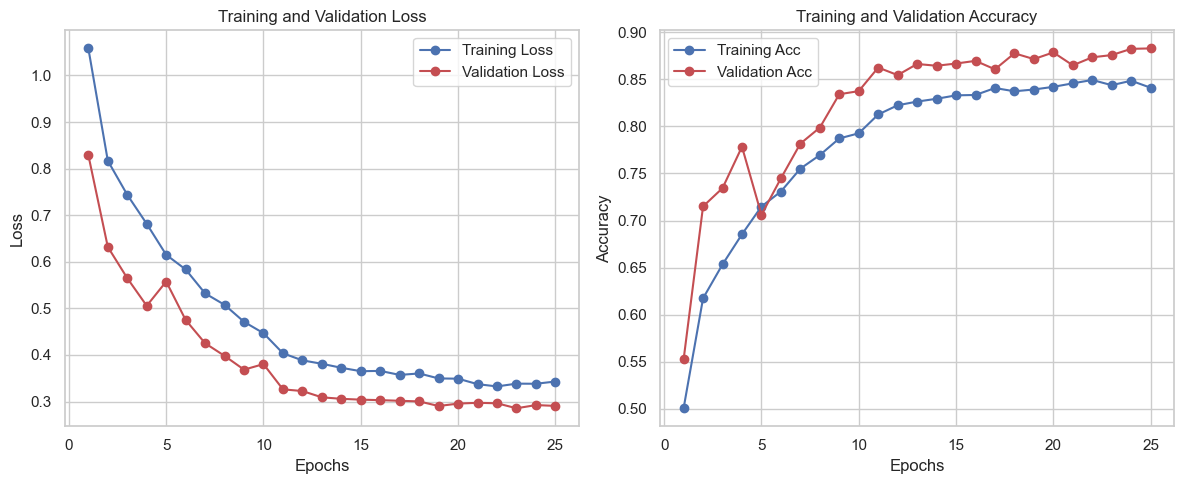

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

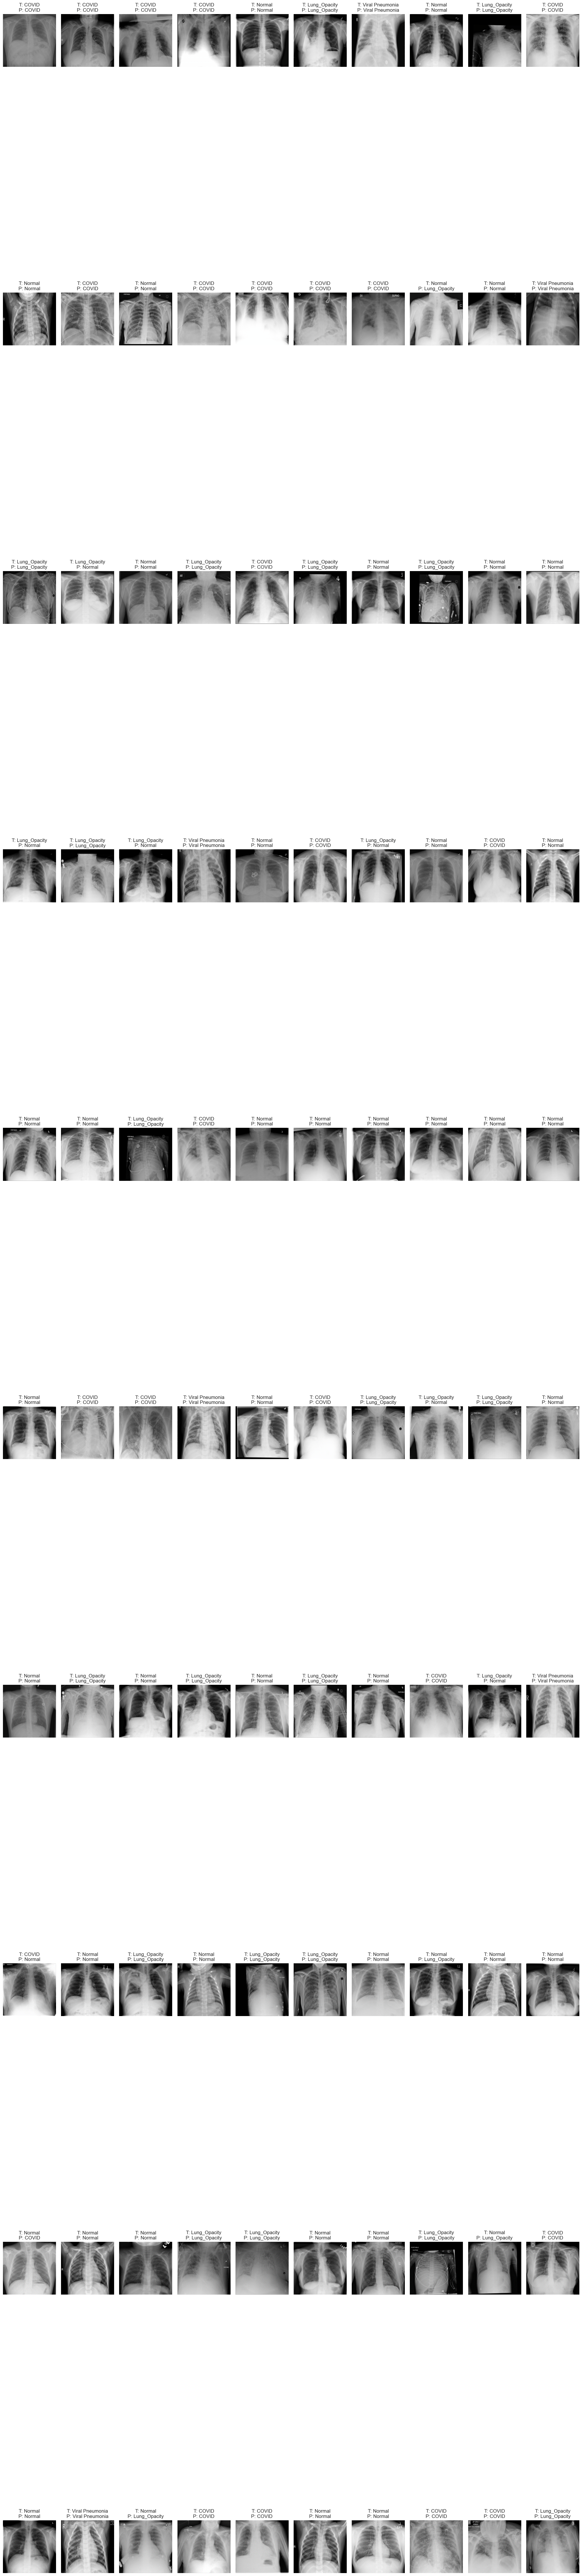

In [79]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
